## Example queries with pyEmdat
This notebook shows a set of example queries using an EMDAT dataset of disaster events since 1960 for the world:
* number of events for selected countries/dates/hazards
* disaster stats for selected countries/dates/hazards (grouped by hazard or country)
* breakdown of disaster impacts for a single period (grouped by hazard or country)
* annual average loss (CPI rebased)

pyEmdat makes these queries easy: just load the data as an *emdat* object then use the built-in methods which filter, group and aggregate the individual disaster records to produce the required outputs.

In [92]:
# imports
import pandas as pd
import pylab as plt

# pyEmdat
from pyEmdat.emdat_df import emdat

In [94]:
# additional imports
import warnings
warnings.filterwarnings('ignore')

import matplotlib.ticker as ticker
%pylab inline

# config
import os
data = os.getenv('data')

Populating the interactive namespace from numpy and matplotlib


## 1. Load downloaded Excel file as a PyEmdat object

In [32]:
ED = emdat((data + '/emdat_1960.xlsx'))

In [33]:
ED.data.head()

,dis_no,year,Seq,disaster_group,disaster_subgroup,disaster_type,disaster_subtype,Disaster Subsubtype,event_name,Entry Criteria,...,End Day,deaths,injured,affected,homeless,total_affected,reconstruction_costs,insured_damages,total_damages,CPI
0,1960-0013-CHL,1960,13,Natural,Geophysical,Earthquake,Tsunami,NaN,NaN,Kill,...,22.0,6000.0,3000.0,2000000.0,NaN,2003000.0,NaN,NaN,550000.0,11.568216
1,1960-0026-AIA,1960,26,Natural,Meteorological,Storm,Tropical cyclone,NaN,Donna,Affect,...,4.0,5.0,250.0,NaN,1000.0,1250.0,NaN,NaN,35000.0,11.568216
2,1960-0025-ANT,1960,25,Natural,Meteorological,Storm,Tropical cyclone,NaN,Donna,OFDA,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.568216
3,1960-0024-ATG,1960,24,Natural,Meteorological,Storm,Tropical cyclone,NaN,Donna,OFDA,...,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.568216
4,1960-0030-BGD,1960,30,Natural,Meteorological,Storm,Tropical cyclone,NaN,NaN,Kill,...,9.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.568216


## 2. Time series: number of events
The emdat_df object provides a method disaster_count_timeseries. This returns number of events by year for the parameters supplied (min_year, max_year, countries, disastertype).

In [47]:
df = ED.disaster_count_timeseries(1960, 2000, countries = 'all',
        disastertype = ['Storm','Flood', 'Earthquake','Volcanic activity','Landslide'])

In [49]:
df.head()

disaster_type,Earthquake,Flood,Landslide,Storm,Volcanic activity
year,,,,,
1961,3.0,8.0,2.0,14.0,0.0
1962,4.0,8.0,2.0,13.0,0.0
1963,3.0,8.0,2.0,21.0,3.0
1964,7.0,22.0,1.0,22.0,1.0
1965,8.0,19.0,6.0,19.0,1.0


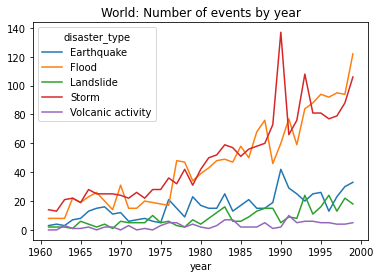

In [35]:
df.plot(title = 'World: Number of events by year');

## 3. Time series grouped by hazard (for selected countries & dates)

In [50]:
df = ED.disaster_stats_timeseries(1960, 2020, 'Mexico','all','deaths')

In [51]:
cols_over_1000 = [column for column in df.columns if df[column].sum() > 1000]
df = df[cols_over_1000]

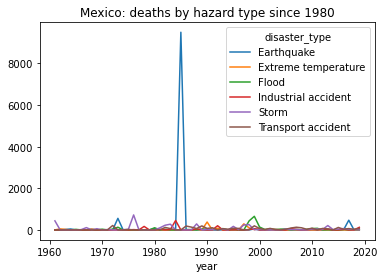

In [53]:
df.plot(title = 'Mexico: deaths by hazard type since 1980');

## 4. Time series grouped by country (for selected dates & hazard)

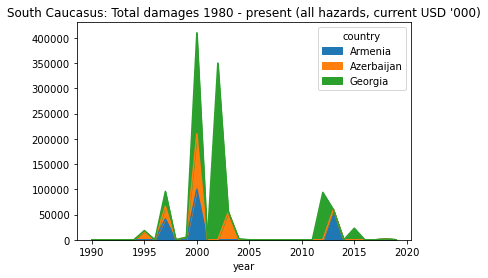

In [56]:
df = ED.country_stats_timeseries(1980, 2020, ['Georgia','Armenia','Azerbaijan'],'all','total_damages')
ax = df.plot.area(title = "South Caucasus: Total damages 1980 - present (all hazards, current USD '000)")

## 5. Annual average loss grouped by hazard
* Note: EMDAT records losses in nominal USD (ie. current dollar values of a given year). The nominal figures over-represent recent disasters vs those several decades ago.
* The method below provides annual average loss (sum of loss / n_years) adjusted into real USD for the given year, using the Bureau of Labor Statistics CPI index.

In [70]:
df = ED.aal_by_disaster_type(1960, 2020, 'Peru', 'all',base_year=2010)

In [71]:
df = df[df>0]

In [72]:
df

disaster_type
Earthquake                75964
Flood                     54028
Landslide                 39772
Mass movement (dry)       25292
Drought                    8912
Extreme temperature        1517
Transport accident         1505
Miscellaneous accident      589
Storm                       285
Industrial accident          56
dtype: int64

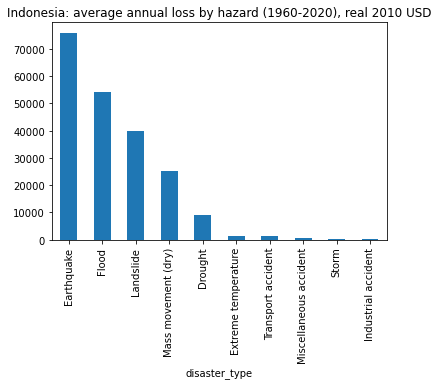

In [73]:
ax = df.plot(kind = 'bar')
plt.title('Indonesia: average annual loss by hazard (1960-2020), real 2010 USD');

In [88]:
country = 'Indonesia'
df_decades=pd.DataFrame({'1970s': ED.aal_by_disaster_type(1970, 1980, country, 'all',base_year=2010),
                        '1980s':ED.aal_by_disaster_type(1980, 1990, country, 'all',base_year=2010),
                        '1990s':ED.aal_by_disaster_type(1990, 2000, country, 'all',base_year=2010),
                        '2000s':ED.aal_by_disaster_type(2000, 2010, country, 'all',base_year=2010),
                        '2010s':ED.aal_by_disaster_type(2010, 2020, country, 'all',base_year=2010)})
df_decades = df_decades.fillna(0)
df_decades['mean'] = df_decades.mean(axis=1)
df_decades.sort_values(ascending=False, by='mean')
df_decades=df_decades[:4]
df_decades.drop(columns='mean',inplace=True)


In [89]:
def thousands(x, pos):
    return('{:,.0f}'.format(x*1e-3))

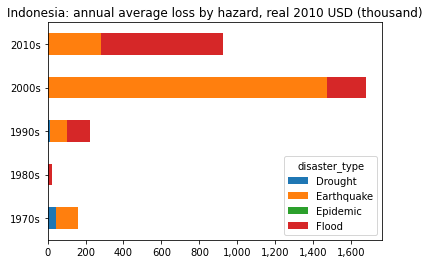

In [91]:
ax = df_decades.T.plot(kind='barh',stacked=True)
plt.title('Indonesia: annual average loss by hazard, real 2010 USD (thousand)')
x_labels = ax.get_xticks()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands));